# Introduction

During this practice, we will look at decision trees and ensemble models, including gradient boosting; we will use the well-known drug solubility regression task as a toy problem.

Since our target topics are pretty hard by themself, we won't do any EDA and preprocessing today and will simply download the ready-to-use data matrices:

In [1]:
!gdown 1W8vwqRFeMq6yBvLK4KYWPbcg3cAk2ryh
!unzip SolData.zip

Downloading...
From: https://drive.google.com/uc?id=1W8vwqRFeMq6yBvLK4KYWPbcg3cAk2ryh
To: /content/SolData.zip
100% 187k/187k [00:00<00:00, 6.93MB/s]
Archive:  SolData.zip
  inflating: solTrainY.csv           
   creating: __MACOSX/
  inflating: __MACOSX/._solTrainY.csv  
  inflating: solTrainX.csv           
  inflating: __MACOSX/._solTrainX.csv  
  inflating: solTestX.csv            
  inflating: __MACOSX/._solTestX.csv  
  inflating: solTrainXtrans.csv      
  inflating: __MACOSX/._solTrainXtrans.csv  
  inflating: solTestY.csv            
  inflating: __MACOSX/._solTestY.csv  
  inflating: solTestXtrans.csv       
  inflating: __MACOSX/._solTestXtrans.csv  


In [2]:
import pandas as pd
import numpy as np

Xtrain = pd.read_csv('solTrainXtrans.csv', index_col=0).reset_index(drop=True)
Ytrain = pd.read_csv('solTrainY.csv', index_col=0)
Xtrain.shape, Ytrain.shape

((951, 228), (951, 1))

In [3]:
Xtest = pd.read_csv('solTestXtrans.csv', index_col=0).reset_index(drop=True)
Ytest = pd.read_csv('solTestY.csv', index_col=0)
Xtest.shape, Ytest.shape

((316, 228), (316, 1))

For each molecule, there are 228 descriptors (features) and only one target variable, the normalized solubility value.

In [4]:
Xtrain.head(5)

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
0,0,1,0,0,1,0,0,1,0,0,...,4.177811,0.584815,0.000000,0.000,0.000,0.000,1.386294,-1.606542,6.812456,6.812456
1,0,1,0,1,1,1,1,1,0,0,...,5.092358,0.642355,0.693147,0.375,0.000,0.000,1.609438,-0.441330,9.753834,12.029604
2,1,1,1,1,1,0,0,1,0,1,...,4.023944,0.000000,1.098612,0.000,0.000,0.000,0.693147,-0.384859,8.245324,8.245324
3,0,0,1,0,0,0,1,0,0,0,...,3.510455,0.000000,0.000000,0.000,0.000,0.000,0.693147,-2.373472,0.000000,0.000000
4,0,0,1,1,1,1,0,0,1,0,...,3.317541,0.694335,0.000000,0.000,0.375,0.375,0.693147,-0.070987,9.913535,9.913535


# Target metric

To select the target metric (and the loss), we need to clearly understand the nature of the problem and the 'cleanness'  of our data.

Here are a few guidelines:
* MSE - clean data without outliers
* MAE/Huber loss - data with potential outliers and/or large values range
* $R^2$ - linear models; in many cases, it is not suitable for models comparison
* ....

Before making a decision let's check the distribution of our targets:

In [6]:
!pip install seaborn

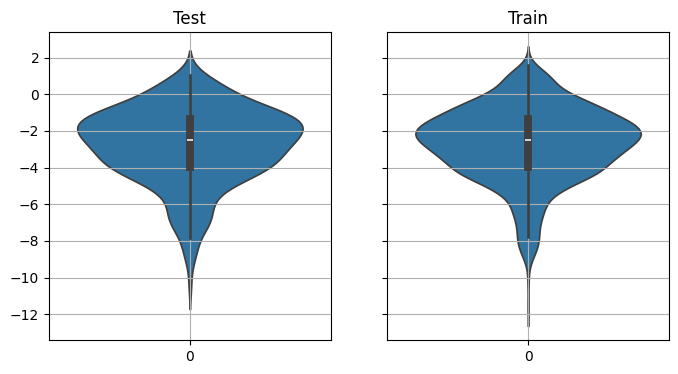

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for ax, title, data in zip(axes, ["Test", "Train"], [Ytest.values, Ytrain.values]):
  sns.violinplot(data=data, ax=ax)
  ax.grid()
  ax.set_title(title)

We have some outliers; therefore, we will use mean absolute error (MAE) as both our target loss and the target metric.

In [9]:
from sklearn.metrics import mean_absolute_error as mae

# Decision Trees

![](https://bookdown.org/tpinto_home/Beyond-Additivity/tree.png)

Decision tree is a very popular model presented in many machine learning courses. In a sense, this is even simpler than the linear model.

Everything we will showcase today will relate to the regression type problem. However, fear not, we will mention the specifics of classification too.

**Prediction process:**
Classification/Regression of current sample starts from the root, and then moves on to one or another child based on some simple rules. The process continues until the leaf is reached.
The "routing" rules and target classes in each leaf are learned during training.

The "rules" which define the route for current sample is basically an "if-else statement" that you encounter at each node, e.g. comparison of a single numerical feature with some threshold. By dividing samples into two groups based on this rule, we are essentialy dividing the feature space into parts. This is called **piecewise linear approximation** of our target variable.

## Algorithm

The classical decision tree training algorithm is an iterative process that follows two simple steps:
1. Stop if reached termination criteria (max depth, min samples in the node, etc).
2. Find a split (variable & threshold) that optimizes the selected criteria(~loss).
3. Create child nodes and continue the process recursively.
The process starts at the root with the whole dataset available.

Common variants of the above procedure deal with two questions: how to select the variable to split data subset in each node and what is seemingly a good optimization criterion. For example, we might do an exhaustive search comparing all possible splits for all features, discard features with low variance or no difference between classes, or pick randomly.


## Criterions

### Main idea

While we are seeking for an optimal split for our current set of samples $X_m$ in the node, we can calculate the constant value $c$ of the target variable that would be predicted by the tree, assuming that this node would be terminal.

This constant should minimize the mean value of our loss function:

$$ H(X_m) = \min\limits_{c \in Y} \dfrac{1}{|X_m|} \sum\limits_{(x_i, y_i) \in X_m} L(y_i, c) $$

The value $H(X_m)$ is called **impurity**. The lower the impurity, the better you can approximate the samples in the leaf by the constant.

In order to understand, whether you split is good or not, we should somehow compare the impurity in the parent node with the impurity of two child nodes. The resulsting difference is often called **information gain**.

### Regression

* MSE:

$$ H(X_m) = \dfrac{1}{|X_m|} \sum\limits_{(x_i, y_i) \in X_m} (\overline{y_i} - y_i)^2 $$

* MAE:

$$ H(X_m) = \dfrac{1}{|X_m|} \sum\limits_{(x_i, y_i) \in X_m} (\overline{y_i} - MEDIAN(Y))^2 $$

### Classification

The standard optimization criterion in the classification problem is the Gini criterion:
$$Gini=1-\sum_{cls}^{classes}p_{cls}=1-\sum_{cls}^{classes}\frac{|sample \in cls|}{samples_{node}}$$



## Pros and Cons

Advantages:

* Simple to understand and to interpret. Trees can be visualized.
* Requires little data preparation.
* Able to handle both numerical and categorical data. However, the scikit-learn implementation does not support categorical variables for now.

Disadvantages:

* Decision-tree learners can create over-complex trees that do not generalize the data well.
* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
* Can be biased.

Answer the following questions:

* Can we apply gradient descent to a decision tree model?
* Can we extrapolate a decision tree model on the data far outside the training set?

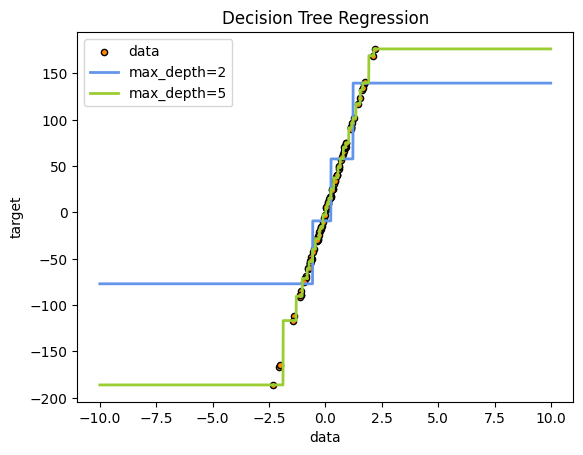

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Create a random dataset
X, y = make_regression(n_samples = 100, n_features = 1, noise = 1, random_state = 1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X[20:80], y[20:80])
regr_2.fit(X[20:80], y[20:80])

# Predict
X_test = np.arange(-10, 10, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

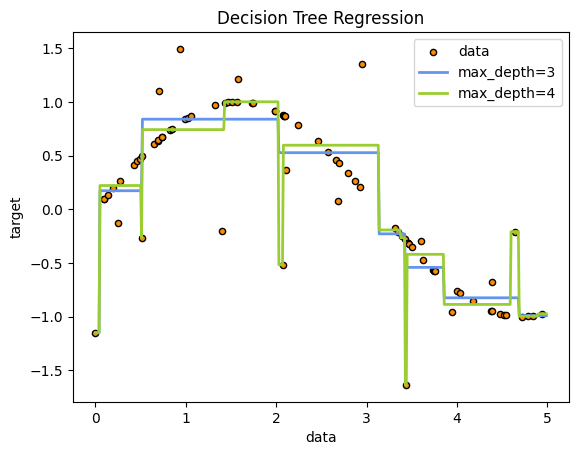

In [ ]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=3)
regr_2 = DecisionTreeRegressor(max_depth=4)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=3", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=4", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Sklearn

Obviously, decision tree learning and inference has been implemented many times before, and our simplified implementation is only useful for better understanding of the process.

Let's see how the sklearn model works ([`sklearn.tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)). In short, their (and many others) implementation has three main parameters:

- `max_depth` – the maximum depth of the tree.
- `max_features` - the maximum number of features to search for the best partition (this is necessary because with a large number of variables it'll be "expensive" to look for the best (according to the information gain-type criterion) partition among *all* variables).
- `min_samples_leaf` – the minimum number of objects in a leaf.This parameter has a clear interpretation: for example, if it is equal to 5, the tree will produce only those classifying rules that are true for at least 5 objects.

You can also tweak the optimization criterion (loss function) if needed.

In [ ]:
from sklearn.tree import export_graphviz

tree = DecisionTreeRegressor(random_state=17, max_depth=3, criterion='absolute_error').fit(Xtrain, Ytrain)

print(f"Decision Tree MAE -> {mae(Ytest, tree.predict(Xtest))}")

Decision Tree MAE -> 0.7991455696202532


In [ ]:
# graphvis is a specialized set of tools to draw graphs
export_graphviz(tree, 'tree.dot', filled=True, feature_names=Xtrain.columns)
!dot -Tpng tree.dot -o tree.png -Gdpi=400

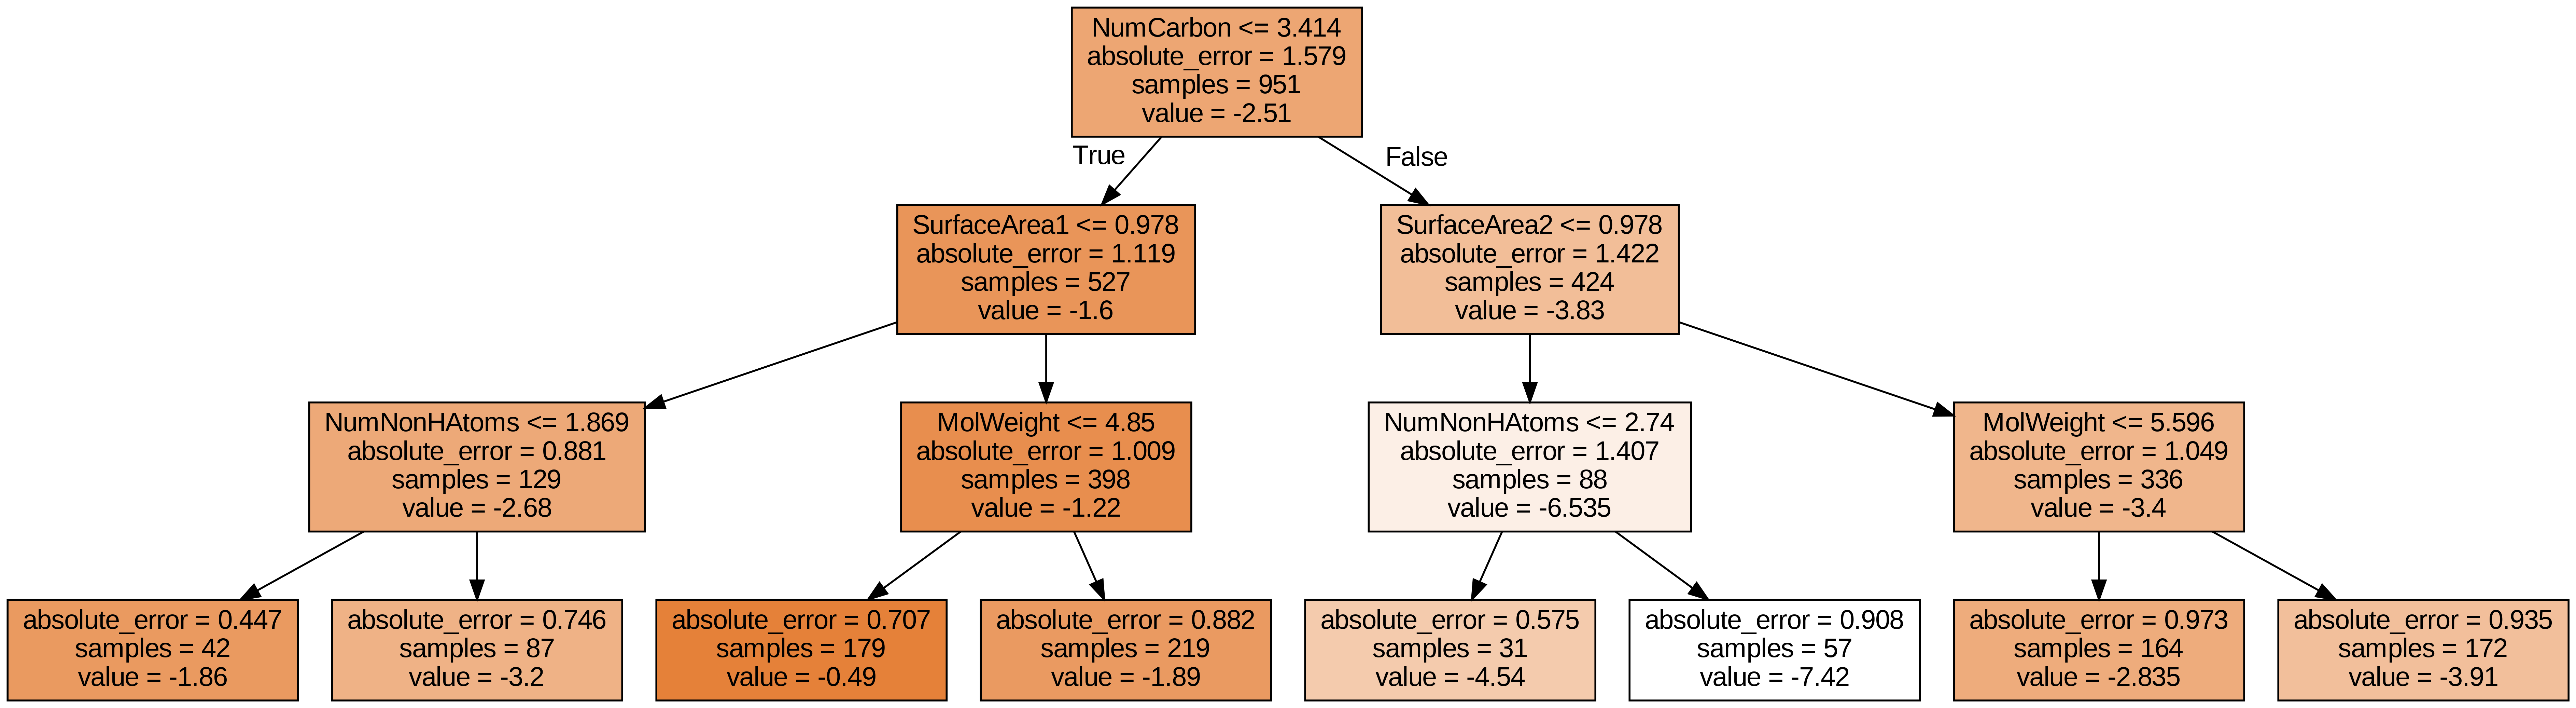

In [ ]:
from IPython.display import Image
Image('tree.png')

Let's look closer at the root of our tree:

In [ ]:
# Calculate median value for the root node (mean in case you're using MSE)
Ytrain.median()

x   -2.51
dtype: float64

In [ ]:
# Calculate MAE for the whole dataset using calculated median value
mae(Ytrain, np.full(len(Ytrain), Ytrain.median()))

1.5792534174553101

In [ ]:
# Check that the shape of the dataset subset is equal to one that you observe on the image above
Xtrain[Xtrain['NumCarbon'] <= 3.414].shape

(527, 228)

## Feature Importance

As with linear models, decision trees are great for assessing the importance of individual features, but unlike LM, there are several ways to do this in a decision tree.

By default sklearn calculates the decrease in node impurity weighted by the probability of reaching that node.

In [ ]:
# Estimated importance values are stored in the .feature_importances_
importance = pd.DataFrame(
    tree.feature_importances_, index=Xtrain.columns, columns=['Importance']
).sort_values(by='Importance', ascending=False)
importance.head()

,Importance
NumCarbon,0.436217
SurfaceArea2,0.179008
MolWeight,0.160944
NumNonHAtoms,0.118972
SurfaceArea1,0.104859


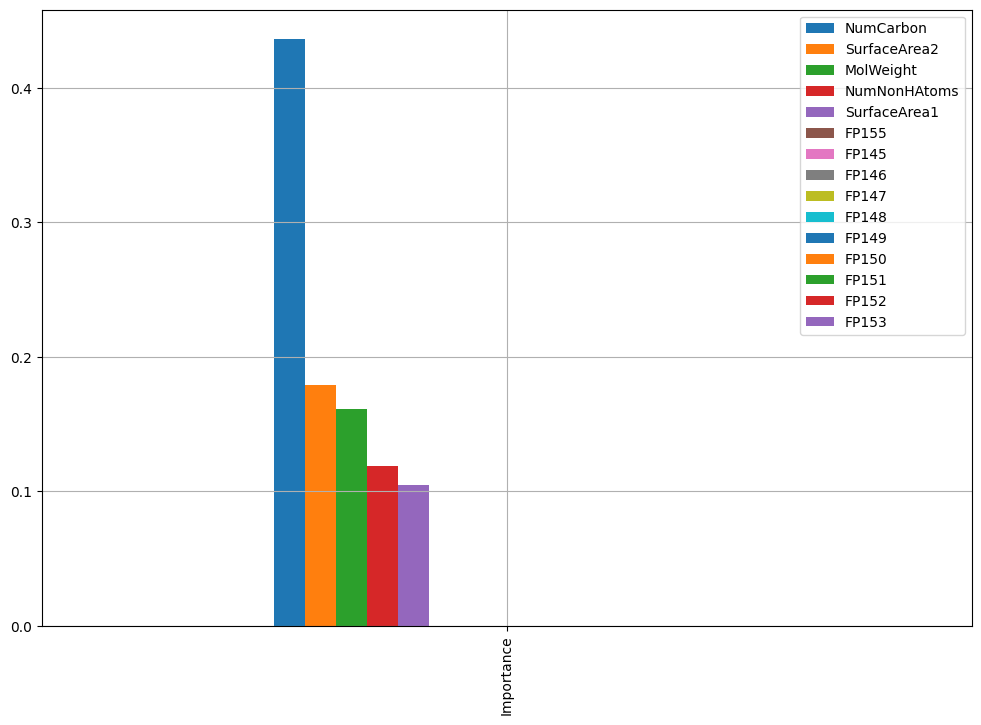

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
importance.iloc[:15].T.plot.bar(ax=plt.gca())
plt.grid()

* *How can we interpret this result?*

# Random Forest

In general, decision trees are relatively efficient but still limited algorithms.

One way to improve the performance of almost any ML model is to use so-called ensembling techniques. The most straightforward and generic ensembling approach is averaging the prediction of several unrelated models (=trained on different data subsets or based on various algorithms).

[Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) is a specialized ensembling technique explicitly developed for the Decision Trees. In short, random forest fits several decision tree classifiers on various bootstrap sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

<center>
<img src="https://tikz.net/janosh/random-forest.png" width=500/>
</center>

In [ ]:
from sklearn.ensemble import RandomForestRegressor

kwargs = dict(
    max_depth=6, min_samples_leaf=50, n_jobs=-1
)

forest = RandomForestRegressor(n_estimators=50, **kwargs).fit(Xtrain, Ytrain)
print("Random forest (N=50):")
mae(Ytest, forest.predict(Xtest))

<ipython-input-41-d6c5fbb1bf92>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor(n_estimators=50, **kwargs).fit(Xtrain, Ytrain)


Random forest (N=50):


0.724455930395299

The good news is that Random Forest hardly overfits and is resistant to too many trained estimators as long as they remain "weak".

In [ ]:
forest = RandomForestRegressor(n_estimators=500, **kwargs).fit(Xtrain, Ytrain)
print("Random forest (N=500):")
mae(Ytest, forest.predict(Xtest))

<ipython-input-42-63593b96d098>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor(n_estimators=500, **kwargs).fit(Xtrain, Ytrain)


Random forest (N=500):


0.7154694934582448

# Gradient Boosting


Gradient boosting is a well-established way to ensemble weak learners, particularly decision trees. It was proven to work exceptionally well in table-like datasets and ranking problems.

Notice that here we didn't specify the type of these "weak learners". In practice, decision trees were empirically shown to demonstrate high speed and precision in many problems. So gradient boosting is almost a synonym for gradient boosting on decision trees now.

## Baseline

Before moving on to complex approaches, it's always a good idea to train and tune the simpler one, also known as baselines. Here we could use, for example, a decision tree or a linear model.

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

lmodel = {
    "alpha": np.linspace(0.1, 1, num=10),
    "l1_ratio": np.linspace(0.1, 1, num=10),
}
tmodel = {
    "criterion": ["absolute_error", "squared_error"],
    "max_depth": np.arange(5, 10),
    "min_samples_leaf": [5, 10, 25, 50]
}

for grid, model, name in [lmodel, ElasticNet(), "Elastic Net"], \
                         [tmodel, DecisionTreeRegressor(), "Decision Tree"]:
  cv = GridSearchCV(model, grid, scoring="neg_mean_absolute_error", cv=3)
  Ypred = cv.fit(Xtrain, Ytrain).predict(Xtest)

  print(f"{name} -> {mae(Ytest, Ypred)}")
  print(f"\t{cv.best_params_}")

Elastic Net -> 0.5938175769009506
	{'alpha': 0.1, 'l1_ratio': 0.1}
Decision Tree -> 0.6366120353050689
	{'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 5}


## Sklearn

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grid = {
    "learning_rate": [0.1, 0.2, 0.4],
    "n_estimators": [50, 100, 250],
    "subsample": [0.75, 1],
    "max_depth": [3, 4],
    "min_samples_leaf": [10, 25]
}

cv = GridSearchCV(GradientBoostingRegressor(),
                  grid, scoring="neg_mean_absolute_error", cv=3)
predY = cv.fit(Xtrain, Ytrain).predict(Xtest)

print(f"Gradient boosting -> {mae(Ytest, predY)}")
print(f"\t{cv.best_params_}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

KeyboardInterrupt: ignored

As we can see, after optimization, the gradient boost achieves an improvement of about 26% compared to the baseline models.

## Resources

Keep in mind that the sklearn boosting implementation is way less optimal than it could be. So you could use it for a fast check, but not in production. See [CatBoost](https://catboost.ai/), [LightGBM](https://lightgbm.readthedocs.io), and [XGBoost](https://xgboost.readthedocs.io) for state-of-the-art solutions and implementations.
